特征筛选不存在对特征值的修改，而更加侧重于寻找那些对模型的性能提升较大的少量特征：

In [1]:
# 导入pandas并且更名为pd。
import pandas as pd
# 从互联网读取titanic数据。
titanic = pd.read_csv(
    'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt')

# 分离数据特征与预测目标。
y = titanic['survived']
X = titanic.drop(['row.names', 'name', 'survived'], axis=1)

# 对对缺失数据进行填充。
X['age'].fillna(X['age'].mean(), inplace=True)
X.fillna('UNKNOWN', inplace=True)

# 分割数据，依然采样25%用于测试。
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=33)

# 类别型特征向量化。
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
X_train = vec.fit_transform(X_train.to_dict(orient='record'))
X_test = vec.transform(X_test.to_dict(orient='record'))

# 输出处理后特征向量的维度。
print(len(vec.feature_names_))

474


In [2]:
# 使用决策树模型依靠所有特征进行预测，并作性能评估。
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.8115501519756839

In [3]:
# 从sklearn导入特征筛选器。
from sklearn import feature_selection
# 筛选前20%的特征，使用相同配置的决策树模型进行预测，并且评估性能。
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20)
X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs, y_test)

0.8206686930091185

In [4]:
# 通过交叉验证的方法，按照固定间隔的百分比筛选特征，并作图展示性能随特征筛选比例的变化。
from sklearn.model_selection import cross_val_score
import numpy as np

percentiles = list(range(1, 100, 2))
results = []

for i in percentiles:
    fs = feature_selection.SelectPercentile(
        feature_selection.chi2, percentile=i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    scores = cross_val_score(dt, X_train_fs, y_train, cv=5)
    results = np.append(results, scores.mean())
print(results)

# 找到提现最佳性能的特征筛选的百分比。
opt = np.where(results == results.max())[0][0]
print('Optimal number of features %d' % percentiles[opt])

[0.85063904 0.85673057 0.87602556 0.88622964 0.86795506 0.86894455
 0.86794475 0.87303649 0.86591424 0.87300557 0.87199546 0.87199546
 0.86289425 0.86487322 0.86385281 0.86689342 0.86488353 0.86180169
 0.86792414 0.86893424 0.8608122  0.8618223  0.86691404 0.86795506
 0.86692435 0.86897547 0.86793445 0.86993403 0.87808699 0.86895485
 0.86996496 0.87505669 0.86794475 0.87200577 0.87302618 0.87300557
 0.87098536 0.87709751 0.86793445 0.86994434 0.86386312 0.86487322
 0.86793445 0.86488353 0.86186353 0.86286333 0.8598021  0.858792
 0.86083282 0.86387343]
Optimal number of features 7


Populating the interactive namespace from numpy and matplotlib


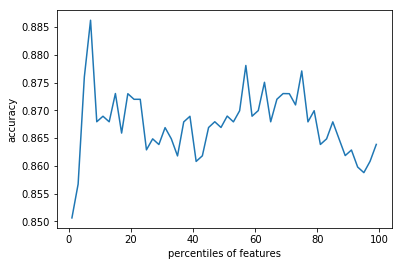

In [5]:
%pylab inline
plt.plot(percentiles, results)
plt.xlabel('percentiles of features')
plt.ylabel('accuracy')
plt.show()

In [6]:
# 使用最佳筛选后的特征，利用相同配置的模型在测试集上进行性能评估。
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=7)
X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs, y_test)

0.8571428571428571